In [73]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
q0=Z-Ne
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
clight = 299792458.0 # m/s

mass0 = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(q0) # eV/c
gamma = np.sqrt( 1 + (p0c/mass0)**2 ) # ion relativistic factor
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [74]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
sequence = xt.Line.from_dict(input_data['line'])

n_part = int(1e4)

SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)

sigma_z = 22.5e-2
nemitt_x = 2e-6
nemitt_y = 2.5e-6

particles = xp.generate_matched_gaussian_bunch(
         num_particles=n_part,
         #total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
         #R_matrix=r_matrix,
         particle_ref=particle_sample,
         tracker=SPS_tracker
         #,steps_r_matrix=steps_r_matrix
         )


sequence.particle_ref = particle_sample
twiss = sequence.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
beta_x=twiss['betx'][-1]
beta_y=twiss['bety'][-1]

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        betx=beta_x,
        bety=beta_y
        )

# arc = xt.LinearTransferMatrix(
#         Q_x=qx, Q_y=qy,        
#         length=circumference,
#         beta_x_0=twiss['betx'][0], beta_x_1=twiss['betx'][-1],
#         beta_y_0=twiss['bety'][0], beta_y_1=twiss['bety'][-1],
#         _context=context
#         )



Loading line from dict:   0%|          | 0/11600 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The argument tracker is deprecated. Please use line instead. <class 'DeprecationWarning'>
*** Maximum RMS bunch length 0.23592919520901076m.
... distance to target bunch length: -2.2500e-01
... distance to target bunch length: 4.4112e-03
... distance to target bunch length: 4.1449e-03
... distance to target bunch length: -3.3479e-03
... distance to target bunch length: 1.0467e-03
... distance to target bunch length: 2.0728e-04
... distance to target bunch length: -3.3833e-06
... distance to target bunch length: 4.9353e-08
... distance to target bunch length: -6.5924e-08
--> Bunch length: 0.22500004935312237
--> Emittance: 0.6606168645424672


In [75]:
##################
# Laser Cooler #
##################

sigma_dp = 2e-4 # relative ion momentum spread

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling


sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))

print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3
#laser_waist_radius = 1.3e-7

laser_energy=1.5e-3
laser_energy=5e-3



Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1034.07 nm


In [76]:
# Given parameters
C_LIGHT = 3e8  # Speed of light in m/s
QELEM = 1.602176634e-19  # Elementary charge in C
hbar = 1.054571817e-34


laser_wavelength=lambda_l
ion_excitation_energy=hw0
w0=laser_waist_radius
laser_Rayleigh_length = np.pi*w0*w0/laser_wavelength
OmegaTransition = ion_excitation_energy*QELEM/hbar
I0 = np.sqrt(2/np.pi)*(laser_energy/sigma_t)/(np.pi*w0*w0)

#############################################################################
# particles.x=0
particles.px=0
# particles.y=0
particles.py=0
particles.zeta=0

#############################################################################
# Particle position and velocity
x, y, z = particles.x,particles.y,particles.zeta  # Particle position in meters
px,py,delta=particles.px,particles.py,particles.delta
pc = p0c*(1.0+delta)
gamma = np.sqrt(1.0 + pc*pc/(mass0*mass0))
beta  = np.sqrt(1.0 - 1.0/(gamma*gamma))
beta_x  = px*p0c/mass0/gamma
beta_y  = py*p0c/mass0/gamma
beta_z  = np.sqrt(beta*beta - beta_x*beta_x -beta_y*beta_y)

vx  = C_LIGHT*beta_x
vy  = C_LIGHT*beta_y
vz  = C_LIGHT*beta_z

# Laser beam properties
laser_x, laser_y, laser_z = 0.0, 0.0, 0.0  # Laser beam center in meters
nx, ny, nz = 0.0, 0.0, -1  # Laser beam direction
laser_waist_shift = 0.0  # Laser waist shift in meters
ion_excited_lifetime  = 76.6e-12

# Collision time calculation
tcol = ((x - laser_x) * nx + (y - laser_y) * ny + (z - laser_z) * nz) / (C_LIGHT - (vx * nx + vy * ny + vz * nz))

# Collision coordinates
xcol = x + vx * tcol
ycol = y + vy * tcol
zcol = z + vz * tcol

# r^2 to the laser center = |r-rl| at the moment tcol:
r2 = (\
    (xcol - (laser_x + C_LIGHT * nx * tcol)) ** 2 + \
    (ycol - (laser_y + C_LIGHT * ny * tcol)) ** 2 + \
    (zcol - (laser_z + C_LIGHT * nz * tcol)) ** 2
)

# Distance from laser focus
Z_to_laser_focus = laser_waist_shift - tcol * C_LIGHT

# Laser beam size at the point of collision
w = w0 * np.sqrt(1.0 + (Z_to_laser_focus / laser_Rayleigh_length) ** 2)

# Max. laser intensity experienced by the ion (in the ion rest frame)
I = 4.0 * gamma**2 * I0 * (w0 / w)**2 * np.exp(-2.0 * r2 / w**2)

# Rabi frequency
OmegaRabi = (hbar * C_LIGHT / (ion_excitation_energy * QELEM)) * \
    np.sqrt(I * 2 * np.pi / (ion_excitation_energy * QELEM * ion_excited_lifetime))

OmegaRabiTau = OmegaRabi * sigma_t / (2.0 * gamma)

# Detuning from the ion transition resonance in the ion rest frame
cos_theta = -(nx * vx + ny * vy + nz * vz) / (gamma * C_LIGHT)
laser_omega_ion_frame = (2.0 * np.pi * C_LIGHT / laser_wavelength) * (1.0 + gamma * cos_theta)
DeltaDetuningTau = abs((OmegaTransition - laser_omega_ion_frame) * sigma_t / (2.0 * gamma))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


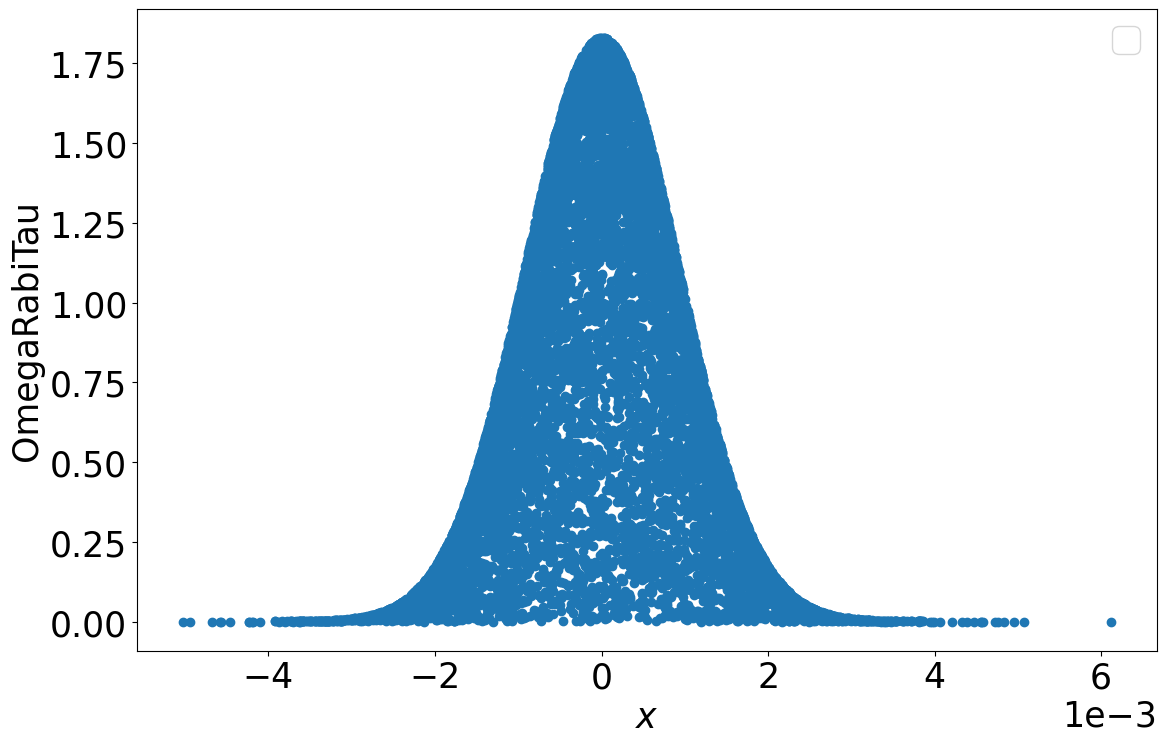

In [77]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(x,OmegaRabiTau)
plt.xlabel(r'$x$')
plt.ylabel('OmegaRabiTau')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.savefig('Histogram_comparison.eps', format='eps', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


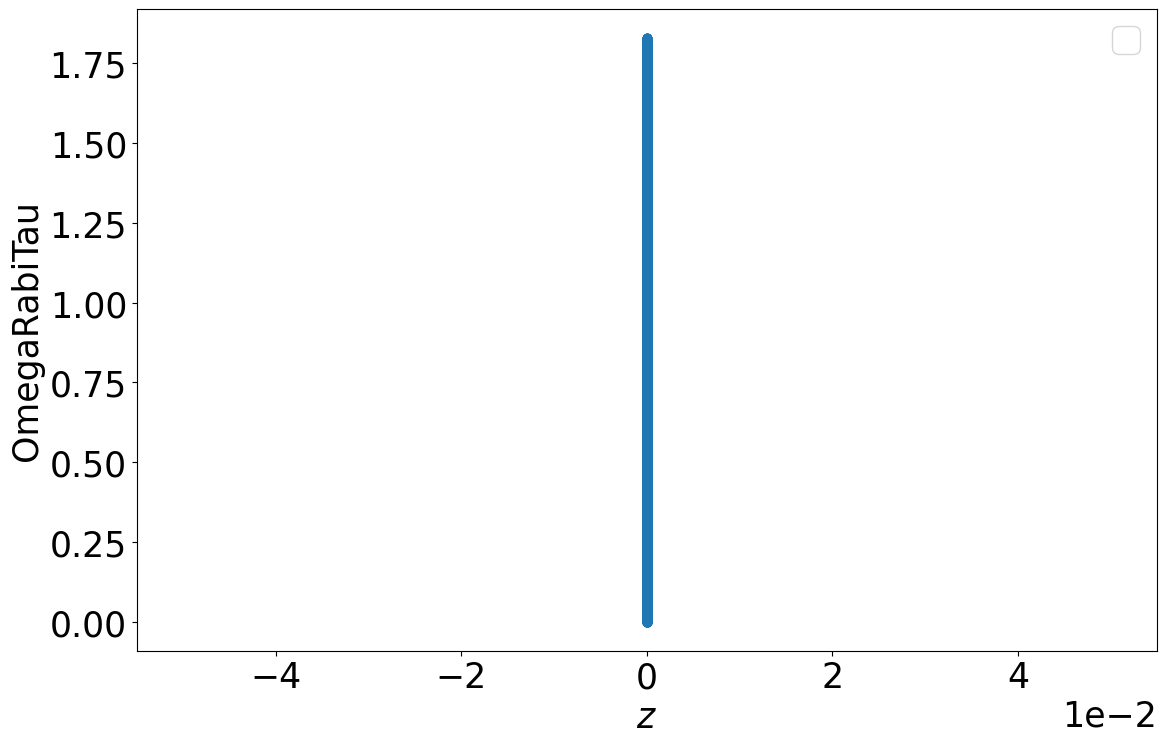

In [78]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(z,OmegaRabiTau)
plt.xlabel(r'$z$')
plt.ylabel('OmegaRabiTau')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.savefig('Histogram_comparison.eps', format='eps', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


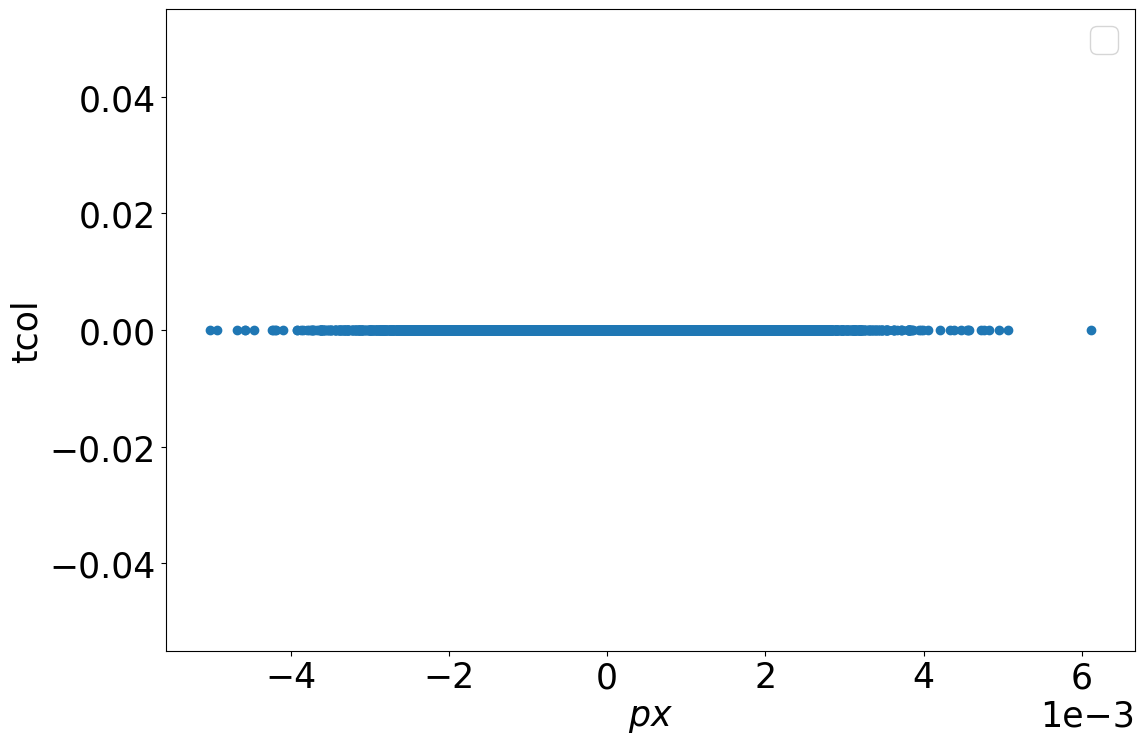

In [79]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(x,tcol)
plt.xlabel(r'$px$')
plt.ylabel('tcol')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.savefig('Histogram_comparison.eps', format='eps', dpi=300)
plt.show()